In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Flatten, Dropout,Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.gridspec import GridSpec

In [2]:
df = pd.read_csv('threat_detection.csv')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [3]:
categorical_cols = ['protocol_type', 'service']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [4]:
features = ['srv_count', 'service', 'src_bytes', 'count', 'protocol_type',
            'dst_host_same_src_port_rate', 'dst_host_diff_srv_rate', 'diff_srv_rate',
            'dst_bytes', 'dst_host_same_srv_rate']
target = 'label'

In [5]:
data = df[features + [target]].copy()

In [6]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

In [7]:
X = data[features].values
y = data['label'].values

In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

In [10]:
y_cat = to_categorical(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_cat, test_size=0.2, random_state=42)

In [12]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_cat.shape[1], activation='softmax'))

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9378 - loss: 0.2321 - val_accuracy: 0.9887 - val_loss: 0.0393
Epoch 2/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9883 - loss: 0.0445 - val_accuracy: 0.9895 - val_loss: 0.0354
Epoch 3/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.9890 - loss: 0.0380 - val_accuracy: 0.9902 - val_loss: 0.0305
Epoch 4/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9904 - val_loss: 0.0300
Epoch 5/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9903 - loss: 0.0316 - val_accuracy: 0.9905 - val_loss: 0.0283
Epoch 6/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9903 - loss: 0.0305 - val_accuracy: 0.9908 - val_loss: 0.0267
Epoch 7/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9906 - loss: 0.0285 - val_accuracy: 0.9909 - val_loss: 0.0264
Epoch 8/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9912 - loss: 0

In [14]:
history = model.fit(X_train, y_train, 
                   epochs=10, 
                   batch_size=64, 
                   validation_data=(X_test, y_test))

Epoch 1/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9921 - loss: 0.0248 - val_accuracy: 0.9927 - val_loss: 0.0237
Epoch 2/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.9922 - loss: 0.0244 - val_accuracy: 0.9926 - val_loss: 0.0237
Epoch 3/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9921 - loss: 0.0239 - val_accuracy: 0.9927 - val_loss: 0.0230
Epoch 4/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9923 - loss: 0.0233 - val_accuracy: 0.9928 - val_loss: 0.0233
Epoch 5/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.9922 - loss: 0.0240 - val_accuracy: 0.9922 - val_loss: 0.0257
Epoch 6/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9925 - loss: 0.0224 - val_accuracy: 0.9929 - val_loss: 0.0219
Epoch 7/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9924 - loss: 0.0222 - val_accuracy: 0.9928 - val_loss: 0.0226
Epoch 8/10
6176/6176 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.9925 - loss: 0

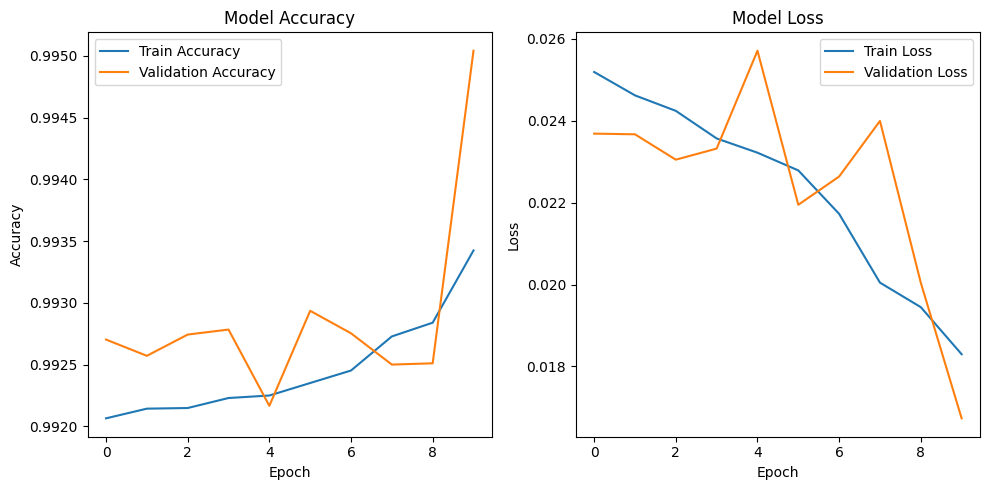

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

Model Accuracy: 99.50%


In [17]:
print(classification_report(
    y_test_classes,
    y_pred_classes,
    labels=np.arange(len(label_encoder.classes_)),
    target_names=label_encoder.classes_,
    zero_division=0
))

                 precision    recall  f1-score   support

           back       0.81      0.58      0.67       431
buffer_overflow       0.00      0.00      0.00        11
      ftp_write       0.00      0.00      0.00         1
   guess_passwd       1.00      0.75      0.86         8
           imap       0.00      0.00      0.00         3
        ipsweep       0.85      0.73      0.78       263
           land       0.00      0.00      0.00         3
     loadmodule       0.00      0.00      0.00         2
       multihop       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00     21408
           nmap       0.50      0.02      0.04        45
         normal       0.98      1.00      0.99     19366
           perl       0.00      0.00      0.00         1
            phf       0.00      0.00      0.00         0
            pod       0.93      0.66      0.77        41
      portsweep       0.91      0.98      0.94       221
        rootkit       0.00    

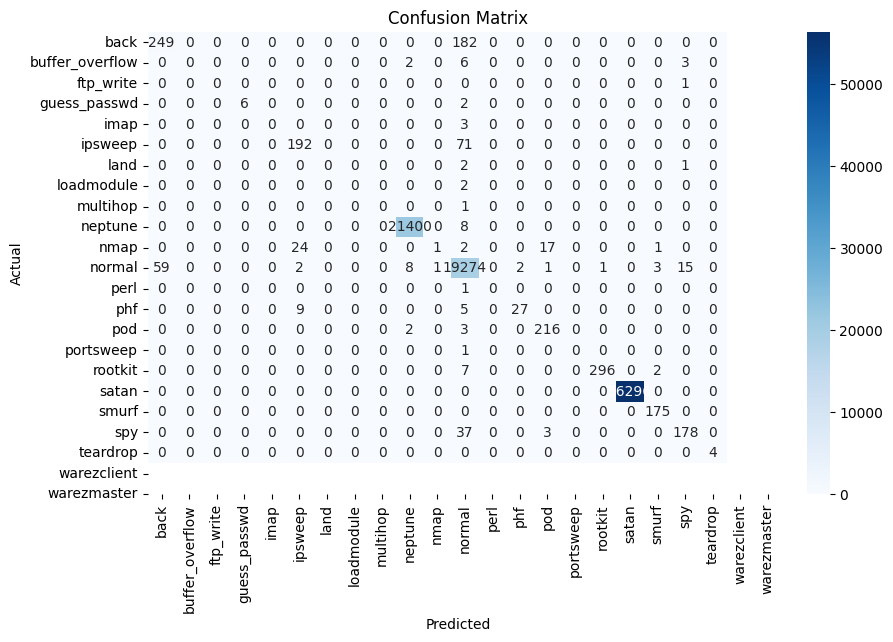

In [18]:
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

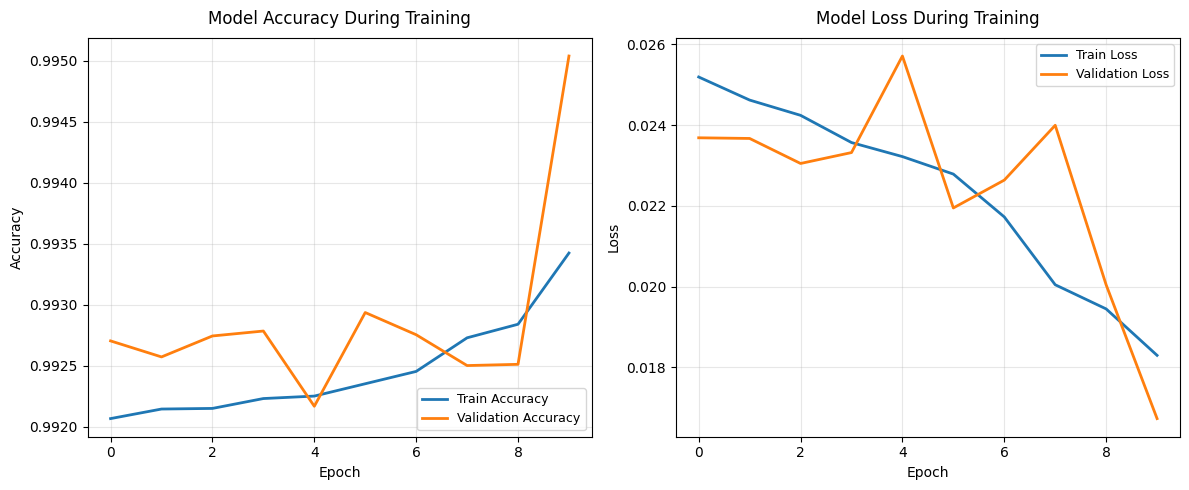

In [19]:
plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[1, 1])

plt.subplot(gs[0])
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy During Training', fontsize=12, pad=10)
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='lower right', fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(gs[1])
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training', fontsize=12, pad=10)
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

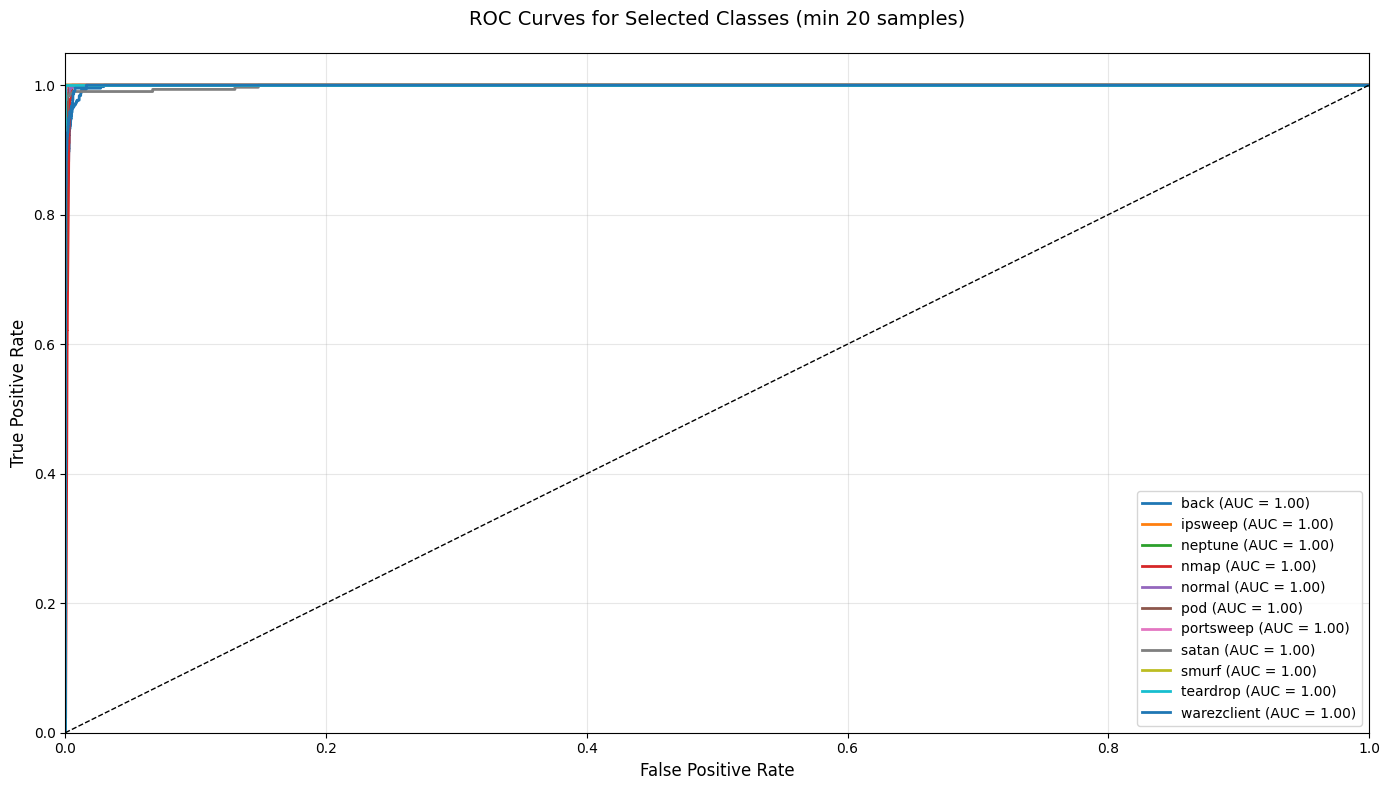

In [20]:
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(14, 8))

y_test_bin = label_binarize(y_test_classes, classes=np.arange(len(label_encoder.classes_)))
y_pred_bin = y_pred

class_counts = np.bincount(y_test_classes)
selected_classes = np.where(class_counts >= 20)[0] 

for i in selected_classes:
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    
    
    if not np.isnan(roc_auc):
        plt.plot(fpr, tpr, lw=2, 
                label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Selected Classes (min 20 samples)', fontsize=14, pad=20)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

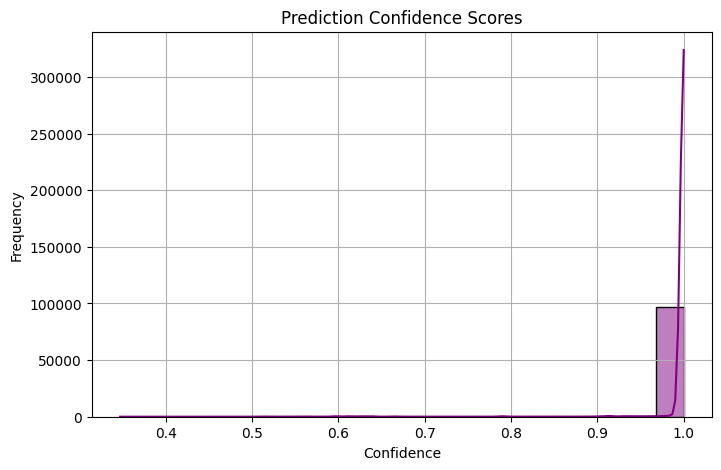

In [21]:
confidence_scores = np.max(y_pred, axis=1)

plt.figure(figsize=(8, 5))
sns.histplot(confidence_scores, bins=20, kde=True, color='purple')
plt.title("Prediction Confidence Scores")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


C:\Users\PARIDHI\AppData\Local\Temp\ipykernel_57240\1460804751.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=actual_counts.values, y=actual_counts.index, palette="viridis")


Text(0, 0.5, 'Class')

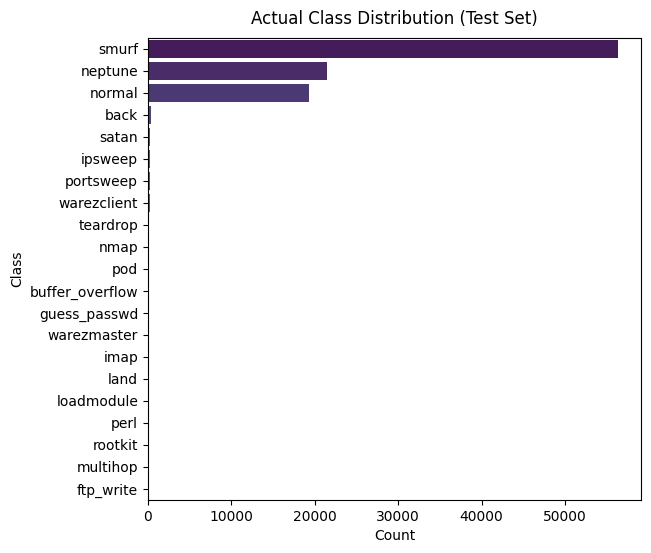

In [22]:
# 4. Class Distribution Comparison
plt.figure(figsize=(14, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Actual distribution
plt.subplot(gs[0])
actual_counts = pd.Series(label_encoder.inverse_transform(y_test_classes)).value_counts()
sns.barplot(x=actual_counts.values, y=actual_counts.index, palette="viridis")
plt.title('Actual Class Distribution (Test Set)', fontsize=12, pad=10)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Class', fontsize=10)

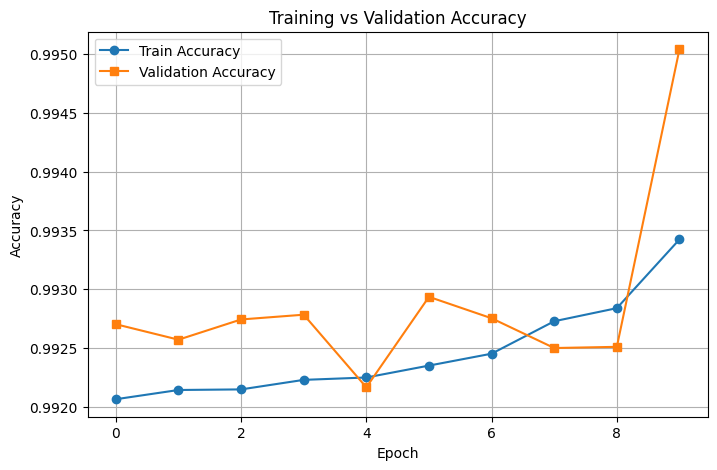

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\PARIDHI\AppData\Local\Temp\ipykernel_57240\129507107.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label_encoder.inverse_transform(y_pred_classes), palette='Set2')


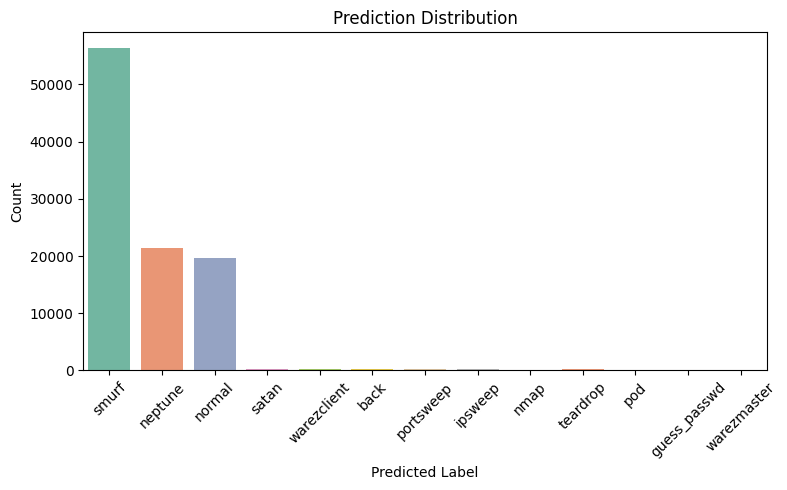

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x=label_encoder.inverse_transform(y_pred_classes), palette='Set2')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')
for col, le in label_encoders.items():
    joblib.dump(le, f'{col}_encoder.pkl')
model.save('cnn_lstm_model.keras')

In [26]:
def predict_sample(input_array):
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    model = load_model('cnn_lstm_model.h5')

    sample_scaled = scaler.transform(input_array)
    sample_reshaped = sample_scaled.reshape(1, sample_scaled.shape[1], 1)
    prediction = model.predict(sample_reshaped)
    predicted_index = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_index])[0]

    if 'normal' in predicted_label.lower():
        print("✅ Normal Activity")
    else:
        print("🚨 Attack Detected")

In [27]:
sample = np.array([[5, 0, 491, 10, 1, 0.0, 0.05, 0.1, 150, 0.9]])  # Normal-like sample
predict_sample(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
✅ Normal Activity


In [28]:
sample_attack = np.array([[100, 1, 0, 200, 0, 0.8, 0.9, 0.95, 0, 0.05]])  # Attack-like sample
predict_sample(sample_attack)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
🚨 Attack Detected
